In [4]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("paper")

In [7]:
def make_simple_plot():
    fig, axes=plt.subplots(figsize=(12,5), nrows=1, ncols=2);
    axes[0].set_ylabel("$y$")
    axes[0].set_xlabel("$x$")
    axes[1].set_xlabel("$x$")
    axes[1].set_yticklabels([])
    axes[0].set_ylim([-2,2])
    axes[1].set_ylim([-2,2])
    plt.tight_layout();
    return axes
def make_plot23():
    fig, axes=plt.subplots(figsize=(12,5), nrows=2, ncols=3);
    axes[0][0].set_ylim([-2,2])
    axes[0][1].set_ylim([-2,2])
    axes[0][2].set_ylim([-2,2])
    axes[1][0].set_ylim([-2,2])
    axes[1][1].set_ylim([-2,2])
    axes[1][2].set_ylim([-2,2])
    axes[0][0].set_ylabel("$y$")
    axes[1][0].set_ylabel("$y$")
    axes[1][0].set_xlabel("$x$")
    axes[1][1].set_xlabel("$x$")
    axes[1][2].set_xlabel("$x$")
    plt.tight_layout();
    return axes
def make_plot():
    fig, axes=plt.subplots(figsize=(15,5), nrows=1, ncols=2);
    axes[0].set_ylabel("$p_R$")
    axes[0].set_xlabel("$x$")
    axes[1].set_xlabel("$x$")
    axes[1].set_yticklabels([])
    axes[0].set_ylim([0,1])
    axes[1].set_ylim([0,1])
    plt.tight_layout();
    return axes

In [5]:
# Import data

path = "/Users/kbrooks/Documents/Data Science Prep/Data/romneysamples.csv"

df=pd.read_csv(path)

df.head()

,f,x,y
0,0.051199,0.01,0.015900
1,0.096800,0.11,0.058539
2,0.102637,0.12,0.072802
3,0.221640,0.27,0.224652
4,0.394863,0.42,0.370738


In [6]:
from sklearn.cross_validation import train_test_split
datasize=df.shape[0]
#split dataset using the index, as we have x,f, and y that we want to split.
itrain,itest = train_test_split(range(datasize),train_size=24, test_size=6)
xtrain= df.x[itrain].values
ftrain = df.f[itrain].values
ytrain = df.y[itrain].values
xtest= df.x[itest].values
ftest = df.f[itest].values
ytest = df.y[itest].values

In [10]:
from sklearn.preprocessing import PolynomialFeatures

def make_features(train_set, test_set, degrees):
    traintestlist=[]
    for d in degrees:
        traintestdict={}
        traintestdict['train'] = PolynomialFeatures(d).fit_transform(train_set.reshape(-1,1))
        traintestdict['test'] = PolynomialFeatures(d).fit_transform(test_set.reshape(-1,1))
        traintestlist.append(traintestdict)
    return traintestlist

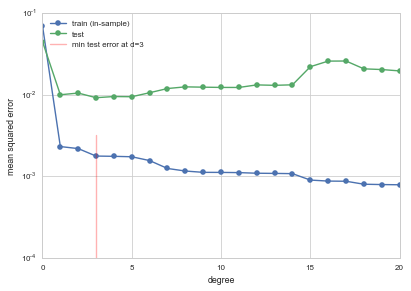

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

degrees=range(21)
error_train=np.empty(len(degrees))
error_test=np.empty(len(degrees))

traintestlists=make_features(xtrain, xtest, degrees)
for d in degrees:#for increasing polynomial degrees 0,1,2...
    Xtrain = traintestlists[d]['train']
    Xtest = traintestlists[d]['test']
    est = LinearRegression()   # this is a constructor (in Python!) for the model
    est.fit(Xtrain, ytrain) # then you do the fit
    #calculate mean squared error using function from sklrn.metrics
    error_train[d] = mean_squared_error(ytrain, est.predict(Xtrain))  # now use model.predict
    error_test[d] = mean_squared_error(ytest, est.predict(Xtest))

plt.plot(degrees, error_train, marker='o', label='train (in-sample)')
plt.plot(degrees, error_test, marker='o', label='test')
plt.axvline(np.argmin(error_test), 0,0.5, color='r', label="min test error at d=%d"%np.argmin(error_test), alpha=0.3)
plt.ylabel('mean squared error')
plt.xlabel('degree')
plt.legend(loc='upper left')
plt.yscale("log")

In [14]:
def plot_functions(est, ax, df, alpha, xtest, Xtest, xtrain, ytrain):
    """Plot the approximation of ``est`` on axis ``ax``. """
    ax.plot(df.x, df.f, color='k', label='f')
    ax.plot(xtrain, ytrain, 's', label="training", alpha=0.4)
    ax.plot(xtest, ytest, 's', label="testing", alpha=0.6)
    transx=np.arange(0,1.1,0.01)
    transX = PolynomialFeatures(20).fit_transform(transx.reshape(-1,1))
    ax.plot(transx, est.predict(transX),  '.', label="alpha = %s" % str(alpha))
    ax.set_ylim((0, 1))
    ax.set_xlim((0, 1))
    ax.set_ylabel('y')
    ax.set_xlabel('x')
    ax.legend(loc='lower right')

In [16]:
def plot_coefficients(est, ax, alpha):
    coef = est.coef_.ravel()
    ax.semilogy(np.abs(coef), marker='o', label="alpha = %s" % str(alpha))
    ax.set_ylim((1e-1, 1e15))
    ax.set_ylabel('abs(coefficient)')
    ax.set_xlabel('coefficients')
    ax.legend(loc='upper left')

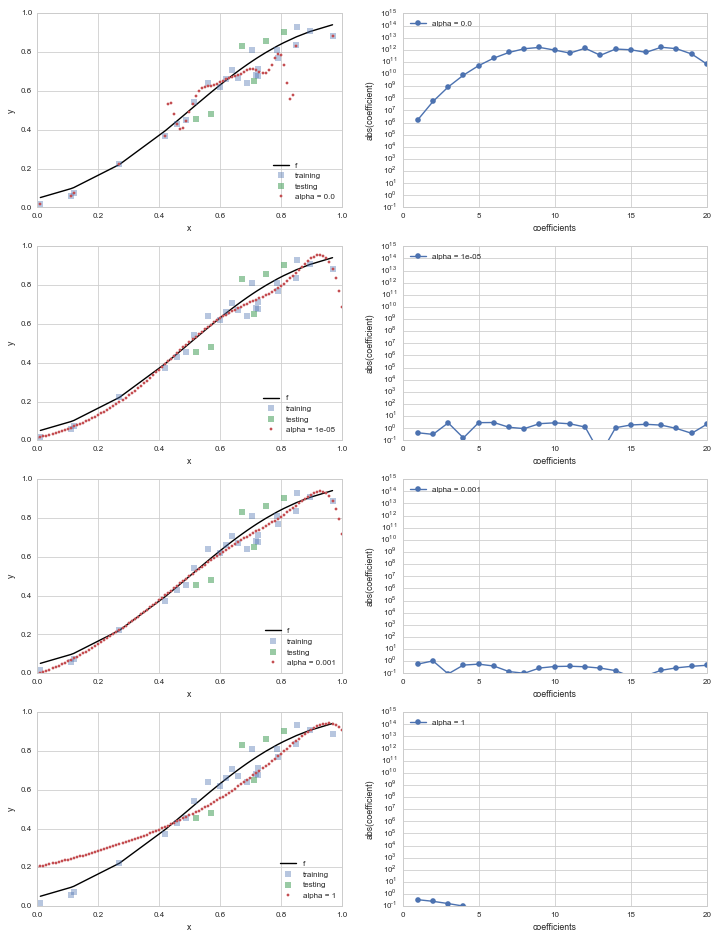

In [17]:
from sklearn.linear_model import Ridge

fig, rows = plt.subplots(4, 2, figsize=(12, 16))
d=20
alphas = [0.0, 1e-5, 1e-3, 1]
Xtrain = traintestlists[d]['train']
Xtest = traintestlists[d]['test']
for i, alpha in enumerate(alphas):
    l,r=rows[i]
    est = Ridge(alpha=alpha)
    est.fit(Xtrain, ytrain)
    plot_functions(est, l, df, alpha, xtest, Xtest, xtrain, ytrain )
    plot_coefficients(est, r, alpha)

In [18]:
# cross validation setup

from sklearn.metrics import make_scorer
#, 1e-6, 1e-5, 1e-3, 1.0
from sklearn.grid_search import GridSearchCV
def cv_optimize_ridge(X, y, n_folds=4):
    clf = Ridge()
    parameters = {"alpha": [1e-8, 1e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 1e-2, 1e-1, 1.0]}
    gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, scoring="mean_squared_error")
    gs.fit(X, y)
    return gs

In [19]:
#stick with d=20
bestmodel = cv_optimize_ridge(Xtrain, ytrain, n_folds=4)


In [20]:
bestmodel.best_estimator_, bestmodel.best_params_, bestmodel.best_score_, bestmodel.grid_scores_

(Ridge(alpha=0.0005, copy_X=True, fit_intercept=True, max_iter=None,
    normalize=False, solver='auto', tol=0.001),
 {'alpha': 0.0005},
 -0.001831453931571331,
 [mean: -0.13269, std: 0.18695, params: {'alpha': 1e-08},
  mean: -0.33366, std: 0.56400, params: {'alpha': 1e-06},
  mean: -0.11520, std: 0.19284, params: {'alpha': 1e-05},
  mean: -0.02827, std: 0.04483, params: {'alpha': 5e-05},
  mean: -0.01240, std: 0.01785, params: {'alpha': 0.0001},
  mean: -0.00183, std: 0.00040, params: {'alpha': 0.0005},
  mean: -0.00279, std: 0.00142, params: {'alpha': 0.001},
  mean: -0.00359, std: 0.00227, params: {'alpha': 0.01},
  mean: -0.00326, std: 0.00138, params: {'alpha': 0.1},
  mean: -0.01490, std: 0.00797, params: {'alpha': 1.0}])

In [21]:
alphawechoose = bestmodel.best_params_['alpha']
clf = Ridge(alpha=alphawechoose).fit(Xtrain,ytrain)

In [22]:
err=mean_squared_error(clf.predict(Xtest), ytest)
errtr=mean_squared_error(clf.predict(Xtrain), ytrain)
errout=0.8*errtr+0.2*err

In [23]:
def plot_functions_onall(est, ax, df, alpha, xtrain, ytrain, Xtrain, xtest, ytest):
    """Plot the approximation of ``est`` on axis ``ax``. """
    ax.plot(df.x, df.f, color='k', label='f')
    ax.plot(xtrain, ytrain, 's', alpha=0.4, label="train")
    ax.plot(xtest, ytest, 's', alpha=0.6, label="test")
    transx=np.arange(0,1.1,0.01)
    transX = PolynomialFeatures(20).fit_transform(transx.reshape(-1,1))
    ax.plot(transx, est.predict(transX), '.', alpha=0.6, label="alpha = %s" % str(alpha))
    #print est.predict(transX)
    ax.set_ylim((0, 1))
    ax.set_xlim((0, 1))
    ax.set_ylabel('y')
    ax.set_xlabel('x')
    ax.legend(loc='lower right')

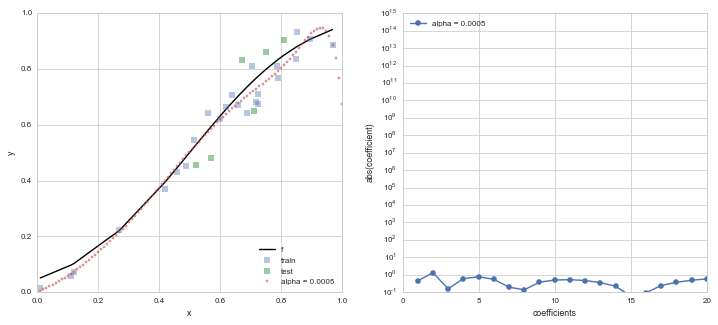

In [24]:
fig, rows = plt.subplots(1, 2, figsize=(12, 5))
l,r=rows
plot_functions_onall(clf, l, df, alphawechoose, xtrain, ytrain, Xtrain, xtest, ytest)
plot_coefficients(clf, r, alphawechoose)